
NLP Pipeline: Sentiment Analysis & Named Entity Recognition
============================================================

A comprehensive implementation of fine-tuned transformer models for 
sentiment classification (IMDB) and named entity recognition (WikiANN).

**Models**: DistilBERT (Sentiment), BERT-Large (NER)

## SETUP & CONFIGURATION

In [2]:
import os, json, math, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import load_dataset, load_from_disk
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, 
    AutoModelForTokenClassification, TrainingArguments, Trainer, 
    DataCollatorForTokenClassification, default_data_collator, TrainerCallback
)
import evaluate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm.auto import tqdm

sns.set_theme()

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

# Model directories
SENTIMENT_MODEL_DIR = Path("/kaggle/working/my_sentiment_model")
NER_MODEL_DIR = Path("/kaggle/working/ner_model_final")
SENTIMENT_MODEL_DIR.mkdir(parents=True, exist_ok=True)
NER_MODEL_DIR.mkdir(parents=True, exist_ok=True)

def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

2025-11-27 21:09:00.577939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764277740.599875    8047 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764277740.606498    8047 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Device: cuda


## CALLBACKS & UTILITIES

In [3]:
class SaveEveryEpochCallback(TrainerCallback):
    """Save model checkpoint at the end of each epoch"""
    def on_epoch_end(self, args, state, control, **kwargs):
        # Access model and tokenizer safely
        model = kwargs.get("model")
        tokenizer = kwargs.get("tokenizer")

        # Determine epoch index
        if state.epoch is None:
            return control
        epoch_idx = int(math.floor(state.epoch))

        out_dir = Path(f"/kaggle/working/checkpoint-epoch-{epoch_idx}")
        out_dir.mkdir(parents=True, exist_ok=True)

        # Save model and tokenizer
        if model:
            model.save_pretrained(str(out_dir))
        if tokenizer:
            tokenizer.save_pretrained(str(out_dir))

        # Save training logs using `state`, not `trainer`
        logs = getattr(state, "log_history", [])
        if logs:
            pd.DataFrame(logs).to_csv('/kaggle/working/training_logs.csv', index=False)

        return control  # Always return control

def plot_training_history(df):
    """Visualize training and validation metrics"""
    if df.empty:
        print("No data to plot")
        return
    
    # Extract epoch-level metrics only
    epoch_metrics = []
    for idx, row in df.iterrows():
        if 'epoch' in row and pd.notna(row['epoch']):
            epoch_val = float(row['epoch'])
            # Only keep end-of-epoch evaluations (integer epochs)
            if abs(epoch_val - round(epoch_val)) < 0.01 and 'eval_loss' in row:
                epoch_metrics.append(row)
    
    if not epoch_metrics:
        print("No epoch-level evaluation data found")
        return
    
    df_plot = pd.DataFrame(epoch_metrics)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss plot
    if 'loss' in df_plot.columns:
        train_loss = df_plot[df_plot['loss'].notna()]
        if not train_loss.empty:
            ax1.plot(train_loss['epoch'], train_loss['loss'], 'b-o', label='Training Loss', linewidth=2)
    
    if 'eval_loss' in df_plot.columns:
        val_loss = df_plot[df_plot['eval_loss'].notna()]
        if not val_loss.empty:
            ax1.plot(val_loss['epoch'], val_loss['eval_loss'], 'r-o', label='Validation Loss', linewidth=2)
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training vs Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    if 'eval_accuracy' in df_plot.columns:
        val_acc = df_plot[df_plot['eval_accuracy'].notna()]
        if not val_acc.empty:
            ax2.plot(val_acc['epoch'], val_acc['eval_accuracy'], 'g-o', label='Accuracy', linewidth=2)
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy')
            ax2.set_title('Validation Accuracy')
            ax2.set_ylim([0, 1])
            ax2.legend()
            ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def load_training_logs(model_dir):
    """Load training history from JSON file"""
    log_file = model_dir / 'train_log_history.json'
    if log_file.exists():
        try:
            with open(log_file, 'r') as f:
                logs = json.load(f)
            return pd.DataFrame(logs)
        except Exception as e:
            print(f"Error loading logs: {e}")
    return pd.DataFrame()

def evaluate_sentiment_model(model, tokenizer, dataset, device="cuda", batch_size=32):
    """Evaluate sentiment model and return predictions"""
    model.to(device)
    model.eval()
    
    if "labels" not in dataset.column_names and "label" in dataset.column_names:
        dataset = dataset.rename_column("label", "labels")
    
    dataset.set_format(type="pt", columns=["input_ids", "attention_mask", "labels"])
    dl = DataLoader(dataset, batch_size=batch_size, collate_fn=default_data_collator)
    
    id2label = {int(k): v for k, v in model.config.id2label.items()}
    
    rows = []
    with torch.no_grad():
        for batch in tqdm(dl, desc="Predicting"):
            batch_device = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
            outputs = model(**{k: v for k, v in batch_device.items() if k in ("input_ids", "attention_mask")})
            logits = outputs.logits.cpu()
            probs = F.softmax(logits, dim=-1).numpy()
            preds = logits.argmax(dim=-1).numpy()
            labels = batch["labels"].cpu().numpy()

            for i in range(len(preds)):
                rows.append({
                    "index": len(rows),
                    "true": int(labels[i]),
                    "pred": int(preds[i]),
                    "pred_label": id2label[int(preds[i])],
                    "confidence": float(probs[i, preds[i]])
                })
    
    return pd.DataFrame(rows)

## SENTIMENT ANALYSIS: DATA PREPARATION

In [4]:
if not (SENTIMENT_MODEL_DIR / 'config.json').exists():
    print('Preparing IMDB dataset for sentiment analysis...')
    
    imdb = load_dataset('imdb')
    tokenizer_sent = AutoTokenizer.from_pretrained('distilbert-base-uncased', use_fast=True)

    train_ds = imdb['train'].shuffle(seed=42)
    val_ds = imdb['test'].shuffle(seed=42).select(range(1000))

    def tokenize_sentiment(batch):
        return tokenizer_sent(batch['text'], truncation=True, padding='max_length', max_length=512)

    tokenized_train = train_ds.map(tokenize_sentiment, batched=True, remove_columns=['text'])
    tokenized_val = val_ds.map(tokenize_sentiment, batched=True, remove_columns=['text'])

    tokenized_train = tokenized_train.rename_column('label', 'labels')
    tokenized_val = tokenized_val.rename_column('label', 'labels')

    tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    tokenized_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    tokenized_train.save_to_disk('/kaggle/working/tokenized_imdb_train')
    tokenized_val.save_to_disk('/kaggle/working/tokenized_imdb_val')
    
    print(f'Training samples: {len(tokenized_train)}, Validation samples: {len(tokenized_val)}')
else:
    print('Sentiment data already prepared')


Sentiment data already prepared


## DATASET EXPLORATORY DATA ANALYSIS

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


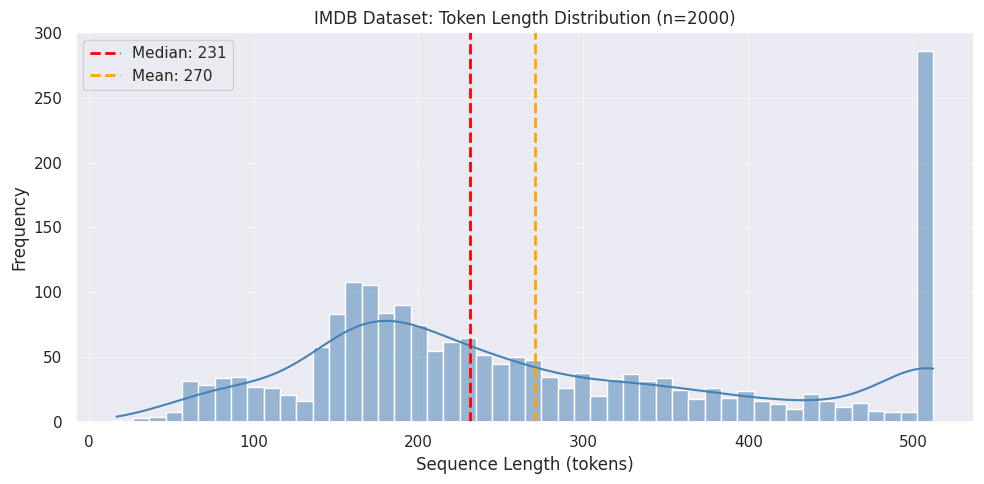

In [5]:
if Path('/kaggle/working/tokenized_imdb_train').exists():
    tokenized_train = load_from_disk('/kaggle/working/tokenized_imdb_train')
    sample_size = min(2000, len(tokenized_train))
    
    lengths = []
    for example in tokenized_train.select(range(sample_size)):
        seq_len = int((np.array(example['input_ids']) != 0).sum())
        lengths.append(seq_len)
    
    lengths = np.array(lengths)
    
    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, bins=50, kde=True, color='steelblue')
    plt.xlabel('Sequence Length (tokens)')
    plt.ylabel('Frequency')
    plt.title(f'IMDB Dataset: Token Length Distribution (n={sample_size})')
    plt.axvline(np.median(lengths), color='red', linestyle='--', linewidth=2, label=f'Median: {int(np.median(lengths))}')
    plt.axvline(np.mean(lengths), color='orange', linestyle='--', linewidth=2, label=f'Mean: {int(np.mean(lengths))}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('imdb_sequence_lengths.png', dpi=300)
    plt.show()


## SENTIMENT ANALYSIS: TRAINING

In [16]:
if not (SENTIMENT_MODEL_DIR / 'config.json').exists():
    print('Training sentiment analysis model...')
    
    set_seed(42)
    tokenizer_sent = AutoTokenizer.from_pretrained('distilbert-base-uncased', use_fast=True)
    model_sent = AutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', 
        num_labels=2,
        id2label={0: 'NEGATIVE', 1: 'POSITIVE'},
        label2id={'NEGATIVE': 0, 'POSITIVE': 1}
    )
    model_sent.to(DEVICE)

    tokenized_train = load_from_disk('/kaggle/working/tokenized_imdb_train')
    tokenized_val = load_from_disk('/kaggle/working/tokenized_imdb_val')

    batch_size = 32 if DEVICE == 'cuda' else 4
    training_args = TrainingArguments(
        output_dir=str(SENTIMENT_MODEL_DIR),
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=2,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_strategy='epoch',  
        logging_steps=100,         
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        fp16=(DEVICE == 'cuda'),
        report_to='none'
    )

    acc_metric = evaluate.load('accuracy')
    
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        return acc_metric.compute(predictions=preds, references=labels)

    trainer = Trainer(
        model=model_sent,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer_sent,
        data_collator=default_data_collator,
        compute_metrics=compute_metrics,
        callbacks=[SaveEveryEpochCallback()]
    )

    trainer.train()
    trainer.save_model(str(SENTIMENT_MODEL_DIR))
    tokenizer_sent.save_pretrained(str(SENTIMENT_MODEL_DIR))
    
    pd.DataFrame(trainer.state.log_history).to_json(
        str(SENTIMENT_MODEL_DIR / 'train_log_history.json'), 
        orient='records', indent=2
    )
    print('Sentiment model training complete')
else:
    print('Sentiment model already trained')

Training sentiment analysis model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_8047/723443570.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.303300,0.232314,0.904000
2,0.179800,0.209969,0.912000
3,0.138700,0.218770,0.913000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Sentiment model training complete


## SENTIMENT ANALYSIS: EVALUATION


SENTIMENT ANALYSIS EVALUATION


Predicting:   0%|          | 0/32 [00:00<?, ?it/s]


Overall Accuracy: 0.913

Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.93      0.90      0.91       512
    POSITIVE       0.90      0.93      0.91       488

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



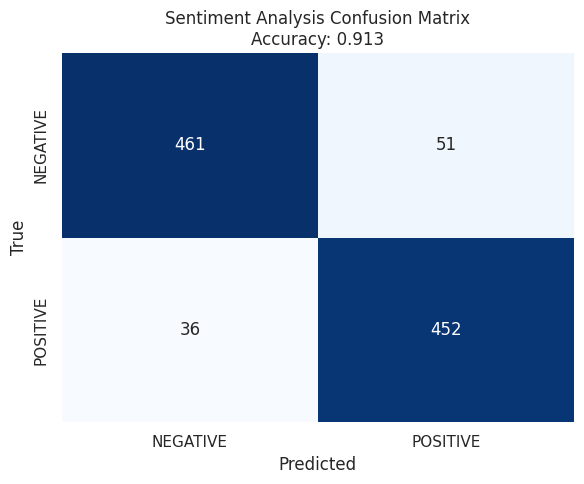

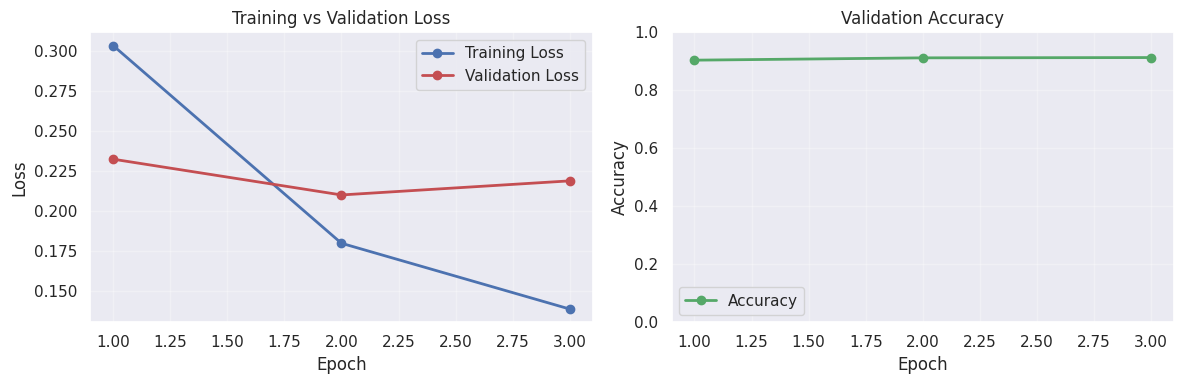

In [17]:
print('\n' + '='*60)
print('SENTIMENT ANALYSIS EVALUATION')
print('='*60)

if (SENTIMENT_MODEL_DIR / 'config.json').exists():
    ds_val = load_from_disk('./tokenized_imdb_val')
    tokenizer = AutoTokenizer.from_pretrained(str(SENTIMENT_MODEL_DIR), use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(str(SENTIMENT_MODEL_DIR))
else:
    print("Sentiment model not found. Please train the model first.")
    model, tokenizer, ds_val = None, None, None

if model is not None:
    df_predictions = evaluate_sentiment_model(model, tokenizer, ds_val, DEVICE)
    df_predictions.to_csv('imdb_predictions.csv', index=False)

y_true = df_predictions["true"].to_numpy()
y_pred = df_predictions["pred"].to_numpy()

accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["NEGATIVE", "POSITIVE"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["NEGATIVE", "POSITIVE"], columns=["NEGATIVE", "POSITIVE"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Sentiment Analysis Confusion Matrix\nAccuracy: {accuracy:.3f}")
plt.tight_layout()
plt.savefig('sentiment_confusion_matrix.png', dpi=300)
plt.show()

# Training history
df_epochs = load_training_logs(SENTIMENT_MODEL_DIR)
if not df_epochs.empty:
    plot_training_history(df_epochs)

## NAMED ENTITY RECOGNITION: DATA PREPARATION

In [8]:
if not (NER_MODEL_DIR / 'config.json').exists():
    print('Preparing WikiANN dataset for NER...')
    
    ner_dataset = load_dataset('wikiann', 'en')
    tokenizer_ner = AutoTokenizer.from_pretrained('dslim/bert-large-NER', use_fast=True)

    # Map dataset labels to model labels
    dataset_labels = ner_dataset['train'].features['ner_tags'].feature.names
    temp_model = AutoModelForTokenClassification.from_pretrained('dslim/bert-large-NER')
    model_label2id = {v: int(k) for k, v in temp_model.config.id2label.items()}
    label_mapping = {i: model_label2id[name] for i, name in enumerate(dataset_labels)}
    del temp_model
    torch.cuda.empty_cache()

    def tokenize_and_align_labels(examples):
        tokenized = tokenizer_ner(
            examples['tokens'], 
            truncation=True, 
            is_split_into_words=True, 
            padding='max_length', 
            max_length=128
        )
        
        labels = []
        for i, label_seq in enumerate(examples['ner_tags']):
            word_ids = tokenized.word_ids(batch_index=i)
            label_ids = []
            prev_word_id = None
            
            for word_id in word_ids:
                if word_id is None:
                    label_ids.append(-100)
                elif word_id != prev_word_id:
                    label_ids.append(label_mapping[label_seq[word_id]])
                else:
                    label_ids.append(-100)
                prev_word_id = word_id
                
            labels.append(label_ids)
        
        tokenized['labels'] = labels
        return tokenized

    tokenized_ner = ner_dataset.map(tokenize_and_align_labels, batched=True)
    tokenized_ner.save_to_disk('/kaggle/working/tokenized_wikiann_en')
    print('NER data preparation complete')
else:
    print('NER data already prepared')


Preparing WikiANN dataset for NER...


Exception ignored in: <function _xla_gc_callback at 0x7f73798a9ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 
Some weights of the model checkpoint at dslim/bert-large-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/20000 [00:00<?, ? examples/s]

NER data preparation complete


## DATASET EXPLORATORY DATA ANALYSIS

Some weights of the model checkpoint at dslim/bert-large-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWa

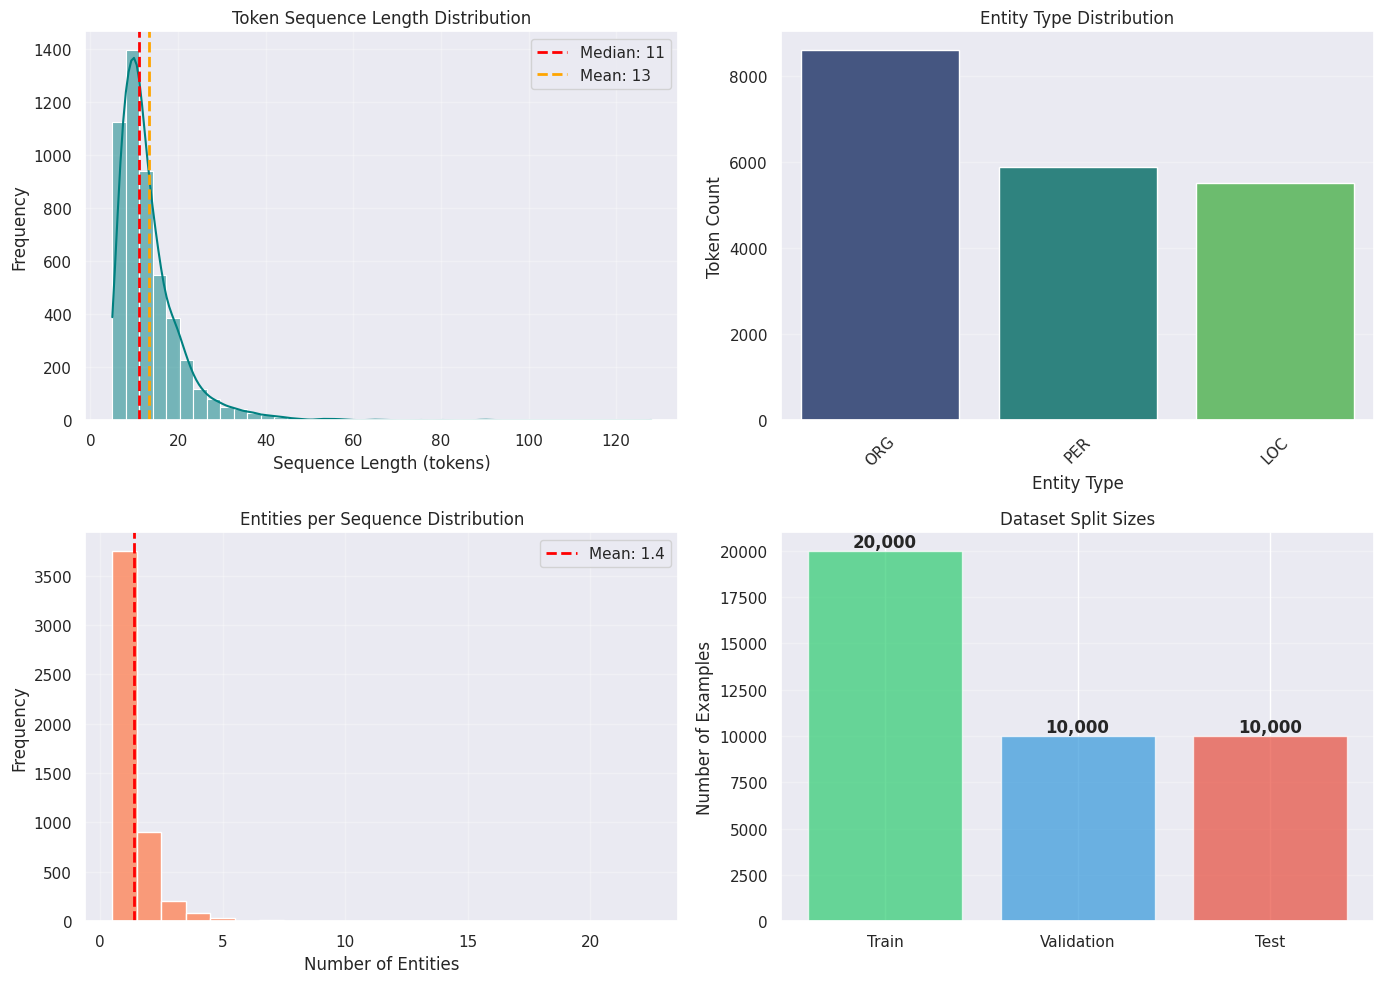

In [9]:
if Path('/kaggle/working/tokenized_wikiann_en').exists():
    tokenized_ner_dataset = load_from_disk('/kaggle/working/tokenized_wikiann_en')
    sample_size = min(5000, len(tokenized_ner_dataset['train']))
    train_sample = tokenized_ner_dataset['train'].select(range(sample_size))
    
    lengths = []
    for example in train_sample:
        seq_len = int((np.array(example['input_ids']) != 0).sum())
        lengths.append(seq_len)
    
    lengths = np.array(lengths)
    
    temp_model = AutoModelForTokenClassification.from_pretrained('dslim/bert-large-NER')
    id2label = temp_model.config.id2label
    del temp_model
    
    entity_counts = {}
    for example in train_sample:
        labels = example['labels']
        for label_id in labels:
            if label_id != -100:
                label_name = id2label[label_id]
                if label_name != 'O':
                    if label_name.startswith('B-') or label_name.startswith('I-'):
                        entity_type = label_name.split('-')[1]
                    else:
                        entity_type = label_name
                    entity_counts[entity_type] = entity_counts.get(entity_type, 0) + 1
    
    entities_per_seq = []
    for example in train_sample:
        labels = example['labels']
        entity_count = 0
        for label_id in labels:
            if label_id != -100:
                label_name = id2label[label_id]
                if label_name.startswith('B-'):
                    entity_count += 1
        entities_per_seq.append(entity_count)
    
    entities_per_seq = np.array(entities_per_seq)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Sequence length distribution
    ax1 = axes[0, 0]
    sns.histplot(lengths, bins=40, kde=True, color='teal', ax=ax1)
    ax1.axvline(np.median(lengths), color='red', linestyle='--', linewidth=2, label=f'Median: {int(np.median(lengths))}')
    ax1.axvline(np.mean(lengths), color='orange', linestyle='--', linewidth=2, label=f'Mean: {int(np.mean(lengths))}')
    ax1.set_xlabel('Sequence Length (tokens)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Token Sequence Length Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Entity type distribution
    ax2 = axes[0, 1]
    if entity_counts:
        entity_df = pd.DataFrame(list(entity_counts.items()), columns=['Entity', 'Count'])
        entity_df = entity_df.sort_values('Count', ascending=False)
        sns.barplot(data=entity_df, x='Entity', y='Count', palette='viridis', ax=ax2)
        ax2.set_xlabel('Entity Type')
        ax2.set_ylabel('Token Count')
        ax2.set_title('Entity Type Distribution')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Entities per sequence
    ax3 = axes[1, 0]
    sns.histplot(entities_per_seq, bins=range(0, max(entities_per_seq)+2), 
                 discrete=True, color='coral', ax=ax3)
    ax3.axvline(np.mean(entities_per_seq), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(entities_per_seq):.1f}')
    ax3.set_xlabel('Number of Entities')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Entities per Sequence Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Dataset split sizes
    ax4 = axes[1, 1]
    split_data = {
        'Train': len(tokenized_ner_dataset['train']),
        'Validation': len(tokenized_ner_dataset['validation']),
        'Test': len(tokenized_ner_dataset['test'])
    }
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    bars = ax4.bar(split_data.keys(), split_data.values(), color=colors, alpha=0.7)
    ax4.set_ylabel('Number of Examples')
    ax4.set_title('Dataset Split Sizes')
    ax4.grid(True, alpha=0.3, axis='y')
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('wikiann_ner_eda.png', dpi=300, bbox_inches='tight')
    plt.show()

## NAMED ENTITY RECOGNITION: TRAINING

In [10]:
if not (NER_MODEL_DIR / 'config.json').exists():
    print('Training NER model...')
    
    set_seed(42)
    tokenized_ner = load_from_disk('/kaggle/working/tokenized_wikiann_en')
    tokenizer_ner = AutoTokenizer.from_pretrained('dslim/bert-large-NER', use_fast=True)
    model_ner = AutoModelForTokenClassification.from_pretrained('dslim/bert-large-NER')
    model_ner.to(DEVICE)

    # Freeze base layers, fine-tune top layers
    for name, param in model_ner.bert.named_parameters():
        param.requires_grad = False
    for name, param in model_ner.bert.named_parameters():
        if any(f'encoder.layer.{i}' in name for i in [8, 9, 10, 11]):
            param.requires_grad = True

    batch_size = 32 if DEVICE == 'cuda' else 4

    training_args = TrainingArguments(
        output_dir=str(SENTIMENT_MODEL_DIR),
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=2,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_strategy='epoch',  
        logging_steps=100,         
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        fp16=(DEVICE == 'cuda'),
        report_to='none' )

    data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer_ner)
    seq_metric = evaluate.load('seqeval')

    def compute_metrics_ner(pred):
        predictions, labels = pred
        predictions = np.argmax(predictions, axis=2)
        
        true_preds = [
            [model_ner.config.id2label[p] for p, l in zip(pred_seq, lab_seq) if l != -100]
            for pred_seq, lab_seq in zip(predictions, labels)]
        true_labels = [
            [model_ner.config.id2label[l] for p, l in zip(pred_seq, lab_seq) if l != -100]
            for pred_seq, lab_seq in zip(predictions, labels)]
        
        results = seq_metric.compute(predictions=true_preds, references=true_labels)
        return {
            'precision': results['overall_precision'],
            'recall': results['overall_recall'],
            'f1': results['overall_f1'],
            'accuracy': results['overall_accuracy']
    }

    trainer_ner = Trainer(
        model=model_ner,
        args=training_args,
        train_dataset=tokenized_ner['train'],
        eval_dataset=tokenized_ner['validation'],
        data_collator=data_collator,
        compute_metrics=compute_metrics_ner,
        tokenizer=tokenizer_ner,
        callbacks=[SaveEveryEpochCallback()]
    )

    trainer_ner.train()
    trainer_ner.save_model(str(NER_MODEL_DIR))
    tokenizer_ner.save_pretrained(str(NER_MODEL_DIR))
    
    pd.DataFrame(trainer_ner.state.log_history).to_json(
        str(NER_MODEL_DIR / 'train_log_history.json'), 
        orient='records', indent=2
    )
    print('NER model training complete')
else:
    print('NER model already trained')

Training NER model...


Some weights of the model checkpoint at dslim/bert-large-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_8047/1357570165.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_ner = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all inpu

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.615000,0.366324,0.698026,0.771497,0.732925,0.901392
2,0.330100,0.322110,0.739471,0.795934,0.766664,0.913036
3,0.291700,0.311829,0.757218,0.804363,0.780079,0.916255


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return

NER model training complete


## NAMED ENTITY RECOGNITION: EVALUATION


NAMED ENTITY RECOGNITION EVALUATION


Evaluating NER:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Overall NER Performance:
Precision: 0.754
Recall: 0.805
F1 Score: 0.778
Accuracy: 0.917


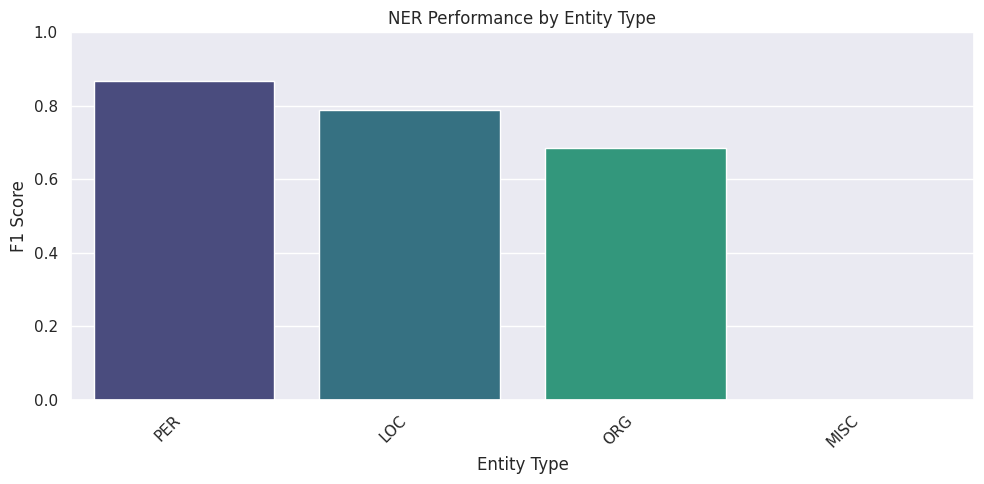

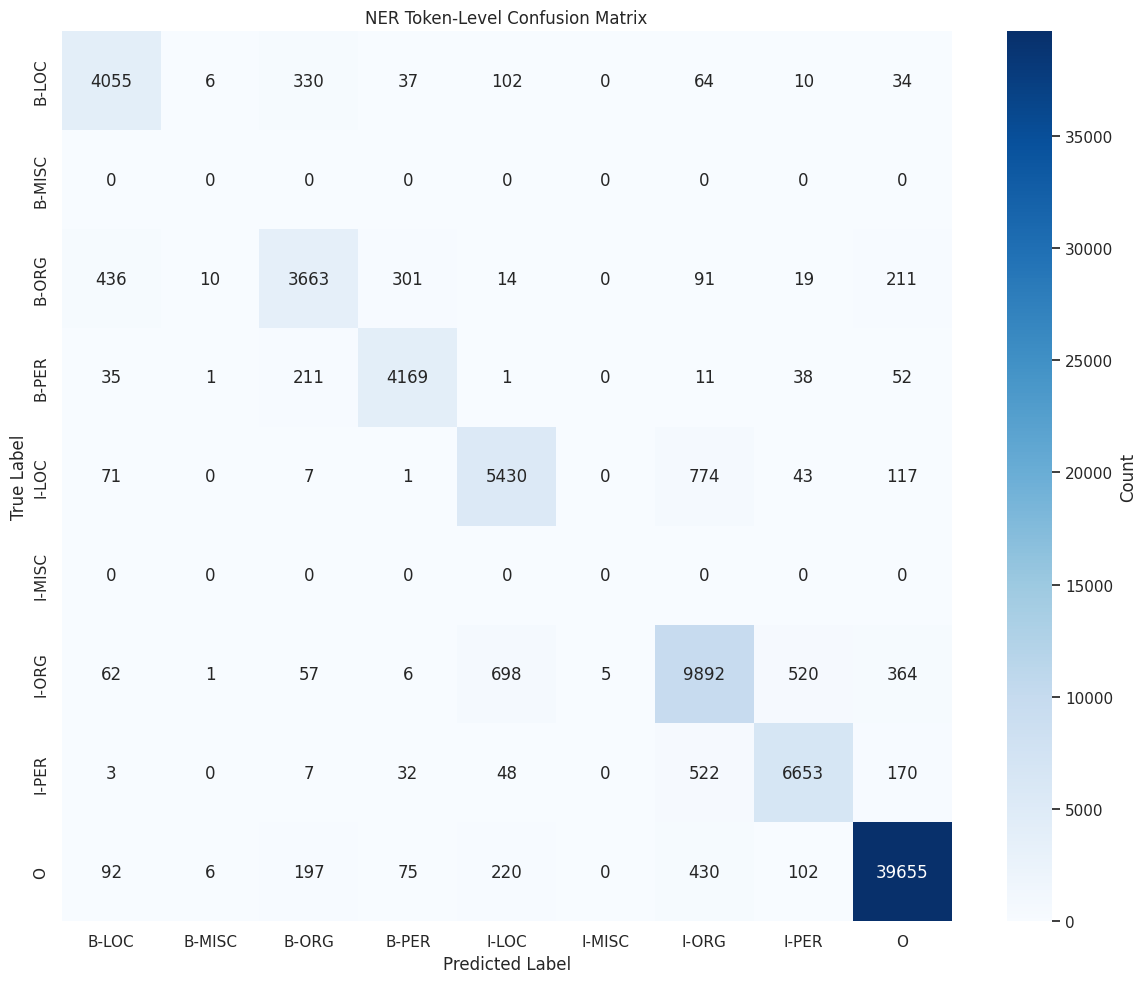

In [11]:
print('\n' + '='*60)
print('NAMED ENTITY RECOGNITION EVALUATION')
print('='*60)

if (NER_MODEL_DIR / 'config.json').exists():
    tokenizer_ner = AutoTokenizer.from_pretrained(str(NER_MODEL_DIR), use_fast=True)
    model_ner = AutoModelForTokenClassification.from_pretrained(str(NER_MODEL_DIR))
    model_ner.to(DEVICE)
    model_ner.eval()
else:
    print("NER model not found. Please train the model first.")
    model_ner, tokenizer_ner = None, None

if model_ner is not None:
    tokenized_ner = load_from_disk('/kaggle/working/tokenized_wikiann_en')
    ds_test = tokenized_ner['test']

    # Prepare dataset
    desired_cols = ["input_ids", "attention_mask", "labels"]
    cols_to_remove = [c for c in ds_test.column_names if c not in desired_cols]
    if cols_to_remove:
        ds_test = ds_test.remove_columns(cols_to_remove)

    dl = DataLoader(ds_test, batch_size=32, shuffle=False, collate_fn=default_data_collator)

# Predictions
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in tqdm(dl, desc="Evaluating NER"):
        batch_device = {k: v.to(DEVICE) for k, v in batch.items() if isinstance(v, torch.Tensor)}
        outputs = model_ner(**batch_device)
        preds = outputs.logits.argmax(dim=-1).cpu().numpy().tolist()
        labels = batch["labels"].cpu().numpy().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels)

# Convert to entity sequences
id2label = {int(k): v for k, v in model_ner.config.id2label.items()}
true_predictions, true_labels = [], []

for pred_seq, lab_seq in zip(all_preds, all_labels):
    seq_preds, seq_labs = [], []
    for p, l in zip(pred_seq, lab_seq):
        if int(l) != -100:
            seq_preds.append(id2label[int(p)])
            seq_labs.append(id2label[int(l)])
    true_predictions.append(seq_preds)
    true_labels.append(seq_labs)

# Compute metrics
seq_eval = evaluate.load("seqeval")
results = seq_eval.compute(predictions=true_predictions, references=true_labels)

print("\nOverall NER Performance:")
print(f"Precision: {results['overall_precision']:.3f}")
print(f"Recall: {results['overall_recall']:.3f}")
print(f"F1 Score: {results['overall_f1']:.3f}")
print(f"Accuracy: {results['overall_accuracy']:.3f}")

# Per-entity F1 scores
entities, f1_scores = [], []
for key, value in results.items():
    if isinstance(value, dict) and "f1" in value:
        entities.append(key)
        f1_scores.append(value["f1"])

if entities:
    df_entities = pd.DataFrame({"entity": entities, "f1": f1_scores}).sort_values("f1", ascending=False)
    df_entities.to_csv("ner_per_entity_f1.csv", index=False)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_entities, x="entity", y="f1", palette="viridis")
    plt.ylim(0, 1)
    plt.xlabel("Entity Type")
    plt.ylabel("F1 Score")
    plt.title("NER Performance by Entity Type")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("ner_per_entity_f1.png", dpi=300)
    plt.show()

# Token-level confusion matrix
flat_true, flat_pred = [], []
for pred_seq, lab_seq in zip(all_preds, all_labels):
    for p, l in zip(pred_seq, lab_seq):
        if int(l) != -100:
            flat_true.append(id2label[int(l)])
            flat_pred.append(id2label[int(p)])

label_names = sorted(set(flat_true + flat_pred))
cm = confusion_matrix(flat_true, flat_pred, labels=label_names)
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Count'})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("NER Token-Level Confusion Matrix")
plt.tight_layout()
plt.savefig("ner_confusion_matrix.png", dpi=300)
plt.show()

## INFERENCE PIPELINE: QUICK TEST

In [12]:
print('\n' + '='*60)
print('INFERENCE PIPELINE')
print('='*60)

def predict_sentiment(text, model, tokenizer):
    """Predict sentiment for a single text"""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=256).to(DEVICE)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = F.softmax(logits, dim=-1).cpu().numpy()[0]
    pred_id = int(logits.argmax(dim=-1).item())
    label = model.config.id2label[pred_id]
    return label, float(probs[pred_id])

def predict_entities(text, model, tokenizer):
    """Extract named entities from text"""
    inputs = tokenizer(text.split(), return_tensors='pt', is_split_into_words=True)
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    preds = outputs.logits.argmax(dim=-1).squeeze().cpu().tolist()
    if isinstance(preds, int):
        preds = [preds]
    
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze().tolist())
    pred_labels = [model.config.id2label[int(p)] for p in preds]
    
    # Merge subword tokens
    display_tokens, display_labels = [], []
    for tok, lab in zip(tokens, pred_labels):
        if tok in tokenizer.all_special_tokens:
            continue
        if display_tokens and tok.startswith('##'):
            display_tokens[-1] += tok[2:]
        else:
            display_tokens.append(tok)
            display_labels.append(lab)
    
    # Extract entities
    entities, current, current_label = [], [], None
    for tok, lab in zip(display_tokens, display_labels):
        if lab == 'O':
            if current:
                entities.append((' '.join(current), current_label))
                current, current_label = [], None
        elif lab.startswith('B-'):
            if current:
                entities.append((' '.join(current), current_label))
            current = [tok]
            current_label = lab.split('-', 1)[1]
        elif lab.startswith('I-'):
            entity_type = lab.split('-', 1)[1]
            if current and current_label == entity_type:
                current.append(tok)
            else:
                current = [tok]
                current_label = entity_type
    
    if current:
        entities.append((' '.join(current), current_label))
    
    return entities

if (SENTIMENT_MODEL_DIR / 'config.json').exists() and (NER_MODEL_DIR / 'config.json').exists():
    # Load models
    model_sent = AutoModelForSequenceClassification.from_pretrained(str(SENTIMENT_MODEL_DIR))
    tokenizer_sent = AutoTokenizer.from_pretrained(str(SENTIMENT_MODEL_DIR))
    model_sent.to(DEVICE)
    model_sent.eval()

    model_ner = AutoModelForTokenClassification.from_pretrained(str(NER_MODEL_DIR))
    tokenizer_ner = AutoTokenizer.from_pretrained(str(NER_MODEL_DIR))
    model_ner.to(DEVICE)
    model_ner.eval()

    # Test examples
    test_examples = [
    "The new Tesla model is amazing, I really enjoyed the ride!",
    "Barack Obama gave a speech at the United Nations today.",
    "Microsoft announced a major update to Windows 12.",
    "Amazon is opening a new warehouse in Germany.",
    "The new Star Wars movie was a mix of action and nostalgia."
    ]

    results = []
    for text in test_examples:
        sentiment, confidence = predict_sentiment(text, model_sent, tokenizer_sent)
        entities = predict_entities(text, model_ner, tokenizer_ner)
        results.append({
            'text': text,
            'sentiment': sentiment,
            'confidence': round(confidence, 3),
            'entities': entities if entities else []
        })

    df_results = pd.DataFrame(results)
    display(df_results)
    df_results.to_csv("inference_results.csv", index=False)
else:
    print("Models not found. Please train both models first.")

print('\n' + '='*60)
print('PIPELINE COMPLETE')
print('='*60)
print('Models saved to:', SENTIMENT_MODEL_DIR, 'and', NER_MODEL_DIR)
print('Evaluation results saved to CSV and PNG files')


INFERENCE PIPELINE


,text,sentiment,confidence,entities
0,"The new Tesla model is amazing, I really enjoy...",POSITIVE,0.988,"[(Tesla model, ORG)]"
1,Barack Obama gave a speech at the United Natio...,POSITIVE,0.847,"[(Barack Obama, PER), (United Nations, ORG)]"
2,Microsoft announced a major update to Windows 12.,POSITIVE,0.694,"[(Microsoft, ORG), (Windows 12, ORG)]"
3,Amazon is opening a new warehouse in Germany.,POSITIVE,0.791,"[(Amazon, ORG), (Germany, LOC)]"
4,The new Star Wars movie was a mix of action an...,POSITIVE,0.952,"[(Star Wars movie, ORG)]"



PIPELINE COMPLETE
Models saved to: /kaggle/working/my_sentiment_model and /kaggle/working/ner_model_final
Evaluation results saved to CSV and PNG files
